<h3>Creating phantom and projections with astra</h3>

In [1]:
from __future__ import division
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
from PIL import Image
import matplotlib.pyplot as plt

import astra

# Configuration.
distance_source_origin = 300  # [mm]
distance_origin_detector = 100  # [mm]
detector_pixel_size = 1.05  # [mm]
detector_rows = 200  # Vertical size of detector [pixels].
detector_cols = 200  # Horizontal size of detector [pixels].
num_of_projections = 180
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)
output_dir = 'dataset/test/'

# Create phantom.
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                          detector_rows)
phantom = np.zeros((detector_rows, detector_cols, detector_cols))
hb = 110  # Height of beam [pixels].
wb = 40   # Width of beam [pixels].
hc = 100  # Height of cavity in beam [pixels].
wc = 30   # Width of cavity in beam [pixels].
phantom[detector_rows // 2 - hb // 2 : detector_rows // 2 + hb // 2,
        detector_cols // 2 - wb // 2 : detector_cols // 2 + wb // 2,
        detector_cols // 2 - wb // 2 : detector_cols // 2 + wb // 2] = 1
phantom[detector_rows // 2 - hc // 2 : detector_rows // 2 + hc // 2,
        detector_cols // 2 - wc // 2 : detector_cols // 2 + wc // 2,
        detector_cols // 2 - wc // 2 : detector_cols // 2 + wc // 2] = 0
phantom[detector_rows // 2 - 5 :       detector_rows // 2 + 5,
        detector_cols // 2 + wc // 2 : detector_cols // 2 + wb // 2,
        detector_cols // 2 - 5 :       detector_cols // 2 + 5] = 0
phantom_id = astra.data3d.create('-vol', vol_geom, data=phantom)

# Create projections. With increasing angles, the projection are such that the
# object is rotated clockwise. Slice zero is at the top of the object. The
# projection from angle zero looks upwards from the bottom of the slice.
proj_geom = \
  astra.create_proj_geom('cone', 1, 1, detector_rows, detector_cols, angles,
                         (distance_source_origin + distance_origin_detector) /
                         detector_pixel_size, 0)
projections_id, projections = \
  astra.creators.create_sino3d_gpu(phantom_id, proj_geom, vol_geom)
projections /= np.max(projections)

# Apply Poisson noise.
#projections = np.random.poisson(projections * 10000) / 10000
#projections[projections > 1.1] = 1.1
#projections /= 1.1

# Save projections.
if not isdir(output_dir):
    mkdir(output_dir)
projections = np.round(projections * 65535).astype(np.uint16)
for i in range(num_of_projections):
    projection = projections[:, i, :]
    with get_writer(join(output_dir, 'proj%04d.png' %i)) as writer:
        writer.append_data(projection, {'compress': 9})

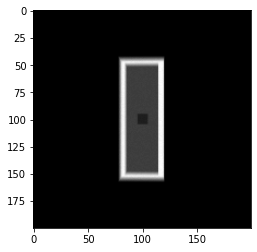

In [3]:
img_arr = ((projections[:,1,:] / 65535)*255).astype(np.uint8)
plt.imshow(img_arr, cmap='gray')


In [4]:
# Cleanup.
astra.data3d.delete(projections_id)
astra.data3d.delete(phantom_id)

0

<h3>Reconstruction from Projection Images</h3>

In [7]:
from __future__ import division
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
import astra

# Configuration.
distance_source_origin = 300  # [mm]
distance_origin_detector = 100  # [mm]
detector_pixel_size = 1.05  # [mm]
detector_rows = 200  # Vertical size of detector [pixels].
detector_cols = 200  # Horizontal size of detector [pixels].
num_of_projections = 180
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)
input_dir = 'dataset/test'
output_dir = 'reconstruction/test'

# Load projections.
projections = np.zeros((detector_rows, num_of_projections, detector_cols))
for i in range(num_of_projections):
    im = imread(join(input_dir, 'proj%04d.tif' % i)).astype(float)
    im /= 65535
    projections[:, i, :] = im

# Copy projection images into ASTRA Toolbox.
proj_geom = \
    astra.create_proj_geom( 'cone', 1, 1, detector_rows, detector_cols, angles,
                            (distance_source_origin + distance_origin_detector) /
                            detector_pixel_size, 0)
projections_id = astra.data3d.create('-sino', proj_geom, projections)

# Create reconstruction.
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                          detector_rows)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('FDK_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)
astra.algorithm.run(algorithm_id)
reconstruction = astra.data3d.get(reconstruction_id)

# Limit and scale reconstruction.
reconstruction[reconstruction < 0] = 0
reconstruction /= np.max(reconstruction)
reconstruction = np.round(reconstruction * 255).astype(np.uint8)

# Save reconstruction.
if not isdir(output_dir):
    mkdir(output_dir)
for i in range(detector_rows):
    im = reconstruction[i, :, :]
    im = np.flipud(im)
    imwrite(join(output_dir, 'reco%04d.png' % i), im)


In [6]:
# Cleanup
astra.algorithm.delete(algorithm_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(projections_id)

In [9]:
vol_geom.items()

dict_items([('option', {'WindowMinX': -100.0, 'WindowMaxX': 100.0, 'WindowMinY': -100.0, 'WindowMaxY': 100.0, 'WindowMinZ': -100.0, 'WindowMaxZ': 100.0}), ('GridRowCount', 200), ('GridColCount', 200), ('GridSliceCount', 200)])